In [54]:
DAILY_EPOCHS = 20
MAX_EPOCHS_TUNER = 1000
HYPERBAND_ITERATIONS = 1
SEED = 13
TRAIN_FOLDER = './trends_tuner/'

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import tensorflow as tf
import contextlib, io
import shutil
import glob
import json
import os

from os import path

from matplotlib import pyplot

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM

from kerastuner import HyperModel
from kerastuner.tuners import Hyperband

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler

sns.set(rc={'figure.figsize':(20,8.27)})
Adam = tf.keras.optimizers.Adam

tf.get_logger().setLevel('ERROR')

# SEED
tf.compat.v1.reset_default_graph()
tf.random.set_seed(SEED)
tf.experimental.numpy.random.seed(SEED)
np.random.seed(SEED)

# Prepare look up data


In [56]:
def look_up(observations, x_data, y_data):
    new_x_data = []
    new_y_data = []

    for i in range(observations ,len(x_data)):
      new_x_data.append(x_data[i-observations : i, : x_data.shape[1]])
      new_y_data.append(y_data[i]) # predict the next record

    new_x_data = np.array(new_x_data)
    new_y_data = np.array(new_y_data)

    new_x_data = np.reshape(new_x_data, (new_x_data.shape[0], new_x_data.shape[1], new_x_data.shape[2]))
    new_y_data = new_y_data[:,0]

    return new_x_data, new_y_data

# Tuner and model

In [57]:
class CustomTuner(Hyperband):
  def run_trial(self, trial, *args, **kwargs):
    has_batch = trial.hyperparameters.Boolean('has_batch')
    if has_batch:
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', [16,32,64,128,256])

    super(CustomTuner, self).run_trial(trial, *args, **kwargs)

In [58]:
class CustomHyperModel(HyperModel):
    def __init__(self, n_steps, n_features):
        self.n_steps = n_steps
        self.n_features = n_features

    def build(self, hp):
        inputs = Input(shape=(self.n_steps, self.n_features))

        last_layer = inputs
  
        units = hp.Int(f'units_initial', min_value=10, max_value=100, step=10)
        number_of_layers = hp.Int('num_layers', 0, 10)

        if number_of_layers > 0:
            last_layer = LSTM(units, activation='relu', return_sequences=True)(inputs)
        else:
            last_layer = LSTM(units, activation='relu')(inputs)

        for i in range(number_of_layers):
            # Layer params

            dropout = hp.Choice(f'dropout_{i}', [0.1, 0.3, 0.5])
            units = hp.Int(f'units_{i}', min_value=10, max_value=100, step=10)
            # Add layer
    
            if (i == number_of_layers - 1):
                last_layer = LSTM(units, activation='relu')(last_layer)
            else:
                last_layer = LSTM(units, activation='relu', return_sequences=True)(last_layer)

            last_layer = Dropout(dropout)(last_layer)

        # Clasificadxor softmax
        predictions = Dense(1, activation="sigmoid")(last_layer) 

        # Unimos las entradas y el modelo mediante la función Model con parámetros inputs y ouputs
        model = Model(inputs=inputs, outputs=predictions) 

        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])
        )

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'] )

        return model

In [59]:
def load_my_model(n_steps, n_model, data_type="vader", reset = False):    
    # Let's load best model for all the tests
    model = load_model(f"{TRAIN_FOLDER}{data_type}/{n_steps}/best_{n_model}.h5")
    model_data = dict(pd.read_csv(f"{TRAIN_FOLDER}{data_type}/{n_steps}/search.csv", index_col=0).iloc[n_model])

    optimizer=Adam(model_data["learning_rate"])
    
    if (reset):
        if os.path.isfile(f"{TRAIN_FOLDER}{data_type}/{n_steps}/best_{n_model}_reset.h5"):
            model = load_model(f"{TRAIN_FOLDER}{data_type}/{n_steps}/best_{n_model}.h5")
        else:
            model = tf.keras.models.clone_model(model)
            model.save(f"{TRAIN_FOLDER}{data_type}/{n_steps}/best_{n_model}_reset.h5", include_optimizer=False)
            model = load_model(f"{TRAIN_FOLDER}{data_type}/{n_steps}/best_{n_model}.h5")
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'] )

    return model, model_data

# Vader

In [60]:
train_features = pd.read_csv('../vader_train/trend/train_features.csv', index_col=0).values
test_features = pd.read_csv('../vader_train/trend/test_features.csv', index_col=0).values
train_target = pd.read_csv('../vader_train/trend/train_target.csv', index_col=0).values
test_target = pd.read_csv('../vader_train/trend/test_target.csv', index_col=0).values

# Split validation
split = int(len(test_target) * 0.5)

val_features = test_features[:split]
val_target = test_target[:split]
test_features = test_features[split:]
test_target = test_target[split:]

assert len(train_features) == len(train_target)
assert len(test_features) == len(test_target)
assert len(val_features) == len(val_target)

## Train

In [61]:
# Validation data = Test data / 2
# scaler for features
scaler = joblib.load("../vader_train/trend/scaler.pkl")
# pca for features
pca = joblib.load("../vader_train/trend/pca.pkl")

val_features = pca.transform(scaler.transform(val_features))
val_target = val_target

In [62]:
step_choices = [3, 7, 14, 60]
for n_steps in step_choices:
    if (
        not path.exists(f"{TRAIN_FOLDER}vader/{n_steps}/search.csv")    
    ):
        print(f"Searching best parameters for: {n_steps}")
        x_train, y_train = look_up(n_steps, train_features, train_target)
        x_val, y_val = look_up(n_steps, val_features, val_target)

        n_features = len(x_train[0][0])

        hypermodel = CustomHyperModel(n_steps, n_features)
        stop_early = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')

        tuner = CustomTuner(
          hypermodel,
          objective='val_accuracy',
          hyperband_iterations=HYPERBAND_ITERATIONS,
          max_epochs=MAX_EPOCHS_TUNER,
          seed=SEED,
          project_name=f'{TRAIN_FOLDER}/vader/{n_steps}'
        )

        tuner.search(x_train, y_train, validation_data=(x_val, y_val), callbacks=[stop_early])

        # Let's store the hyperparameters summary for the best 5 models
        print("saving objects")
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
          tuner.results_summary(10)

        output = f.getvalue()
        pd.DataFrame(
            [{x.split(':')[0]:x.split(':')[1] for x in model_output.split('\n')[2:-1]} for model_output in output.split("Trial summary")[1:]]
        ).to_csv(f"{TRAIN_FOLDER}/vader/{n_steps}/search.csv")
        
        # Let's store the best 5 models
        for idx, step_model in enumerate(tuner.get_best_models(num_models=10)):
            step_model.save(f'{TRAIN_FOLDER}/vader/{n_steps}/best_{idx}.h5', include_optimizer=False)


        # Let's remove the trails now that everything is complete
        print("removing trials")
        for filename in glob.iglob(f"{TRAIN_FOLDER}/vader/{n_steps}/*"):
            if ("trial" in filename): shutil.rmtree(filename)

## Walk forward Validation

In [63]:
# Run transformation for test features
test_features = pca.transform(scaler.transform(test_features))
test_target = test_target

In [64]:
def validate_model(sel_n_steps, sel_n_model, data_type="vader"):
    predictions_path = f"./predictions/{data_type}/{sel_n_steps}/{sel_n_model}.csv"
    
    if path.exists(predictions_path):    
        accuracy_df = pd.read_csv(predictions_path, index_col=0)
    else:
        accuracy_df = pd.DataFrame({"real": [], "predicted": []})
        accuracy_df.to_csv(predictions_path)

    # reset full features to train + val
    full_features = np.vstack([train_features, val_features])
    full_target = np.vstack([train_target, val_target])
    
    # the model accuracy needs to be calculated
    if len(accuracy_df) != len(test_features):
        # Let's simulate a daily observation
        for idx,(daily_x, daily_y) in enumerate(zip(test_features, test_target)):
            # Load model with new weights
            model, model_data = load_my_model(sel_n_steps, sel_n_model, data_type=data_type, reset=True)

            accuracy_df = pd.read_csv(predictions_path, index_col=0)

            # train is what we have before adding the day
            x_train, y_train = look_up(sel_n_steps, full_features, full_target)

            # we add the new day to the features and transform to get today's observation in format
            full_features = np.vstack([full_features, daily_x])
            full_target = np.vstack([full_target, daily_y])
            observation = look_up(sel_n_steps, full_features, full_target)[0][-1:]

            # check if the day was already predicted (in case the long process fails)
            if idx not in accuracy_df.index:
                # train with yesterday's data
                if "True" in model_data['has_batch']:
                    print(f"Training with bach: {model_data['batch_size']}")
                    model.fit(x_train, y_train, epochs=int(model_data['tuner/epochs']), batch_size=int(model_data['batch_size']))
                else:
                    model.fit(x_train, y_train, epochs=int(model_data['tuner/epochs']))

                # Predict for today
                accuracy_df = accuracy_df.append(
                    {"real": daily_y[0], "predicted": model.predict(observation)[0,0]}, 
                    ignore_index=True
                )

                # Store test values
                accuracy_df.to_csv(predictions_path)

In [65]:
step_choices = [3, 7, 14, 60]
for n_steps in step_choices:
    for n_model in range(0,10):
        print("Validating Model: ")
        print(f"N_STEPS: {n_steps}")
        print(f"N_MODEL: {n_model}")
        print("\n")
        validate_model(n_steps, n_model)

Validating Model: 
N_STEPS: 3
N_MODEL: 0


Validating Model: 
N_STEPS: 3
N_MODEL: 1


Validating Model: 
N_STEPS: 3
N_MODEL: 2


Validating Model: 
N_STEPS: 3
N_MODEL: 3


Validating Model: 
N_STEPS: 3
N_MODEL: 4


Validating Model: 
N_STEPS: 3
N_MODEL: 5


Validating Model: 
N_STEPS: 3
N_MODEL: 6


Validating Model: 
N_STEPS: 3
N_MODEL: 7


Validating Model: 
N_STEPS: 3
N_MODEL: 8


Validating Model: 
N_STEPS: 3
N_MODEL: 9


Validating Model: 
N_STEPS: 7
N_MODEL: 0


Validating Model: 
N_STEPS: 7
N_MODEL: 1


Validating Model: 
N_STEPS: 7
N_MODEL: 2


Validating Model: 
N_STEPS: 7
N_MODEL: 3


Validating Model: 
N_STEPS: 7
N_MODEL: 4


Validating Model: 
N_STEPS: 7
N_MODEL: 5


Validating Model: 
N_STEPS: 7
N_MODEL: 6


Validating Model: 
N_STEPS: 7
N_MODEL: 7


Validating Model: 
N_STEPS: 7
N_MODEL: 8


Validating Model: 
N_STEPS: 7
N_MODEL: 9


Validating Model: 
N_STEPS: 14
N_MODEL: 0


Validating Model: 
N_STEPS: 14
N_MODEL: 1


Validating Model: 
N_STEPS: 14
N_MODEL: 2


Validati

In [ ]:
step_choices = [3, 7, 14, 60]
vader_acc = []
for n_steps in step_choices:
    for n_model in range(0,10):
        predictions_path = f"./predictions/vader/{n_steps}/{n_model}.csv"
        accuracy_df = pd.read_csv(predictions_path, index_col=0)

        predicted = list(accuracy_df["predicted"])
        real = list(accuracy_df["real"])
        
        bin_predicted = Binarizer(threshold=0.5).fit_transform([predicted])[0]
        bin_real = real

        pred_df = pd.DataFrame([predicted, bin_predicted, bin_real]).transpose()
        pred_df = pred_df.assign(mid=lambda x:(x[0] > 0.6) | (x[0] < 0.4))
        pred_df = pred_df.assign(high=lambda x:(x[0] > 0.8) | (x[0] < 0.2))

        acc = accuracy_score(pred_df[1], pred_df[2])
        acc_mid = accuracy_score(pred_df.query("mid")[1], pred_df.query("mid")[2])
        acc_high = accuracy_score(pred_df.query("high")[1], pred_df.query("high")[2])
        
        vader_acc.append({"n_steps": n_steps, "n_model": n_model, "acc": acc, "acc_mid": acc_mid, "acc_high": acc_high})

vader_acc = pd.DataFrame(vader_acc)

In [67]:
vader_acc = vader_acc.sort_values(by=["acc"], ascending=False)

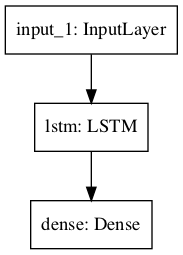

In [71]:
from tensorflow.python.keras.utils.vis_utils import plot_model
best_model, best_params = load_my_model(60, 3, data_type='vader', reset=True)
plot_model(best_model, to_file=f"./predictions/vader/best.png")

# Textblob

In [73]:
# change to textblob
train_features = pd.read_csv('../textblob_train/trend/train_features.csv', index_col=0).values
test_features = pd.read_csv('../textblob_train/trend/test_features.csv', index_col=0).values
train_target = pd.read_csv('../textblob_train/trend/train_target.csv', index_col=0).values
test_target = pd.read_csv('../textblob_train/trend/test_target.csv', index_col=0).values

# Split validation
split = int(len(test_target) * 0.5)

val_features = test_features[:split]
val_target = test_target[:split]
test_features = test_features[split:]
test_target = test_target[split:]

assert len(train_features) == len(train_target)
assert len(test_features) == len(test_target)
assert len(val_features) == len(val_target)

## Train

In [74]:
# Validation data = Test data / 2
# scaler for features
scaler = joblib.load("../textblob_train/trend/scaler.pkl")
# pca for features
pca = joblib.load("../textblob_train/trend/pca.pkl")

val_features = pca.transform(scaler.transform(val_features))
val_target = val_target

In [75]:
step_choices = [3, 7, 14, 60]
for n_steps in step_choices:
    if (
        not path.exists(f"{TRAIN_FOLDER}/textblob/{n_steps}/search.csv")    
    ):
        print(f"Searching best parameters for: {n_steps}")
        x_train, y_train = look_up(n_steps, train_features, train_target)
        x_val, y_val = look_up(n_steps, val_features, val_target)

        n_features = len(x_train[0][0])

        hypermodel = CustomHyperModel(n_steps, n_features)
        stop_early = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')

        tuner = CustomTuner(
          hypermodel,
          objective='val_accuracy',
          hyperband_iterations=HYPERBAND_ITERATIONS,
          max_epochs=MAX_EPOCHS_TUNER,
          seed=SEED,
          project_name=f'{TRAIN_FOLDER}/textblob/{n_steps}'
        )

        tuner.search(x_train, y_train, validation_data=(x_val, y_val), callbacks=[stop_early])

        # Let's store the hyperparameters summary for the best 5 models
        print("saving objects")
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
          tuner.results_summary(10)

        output = f.getvalue()
        pd.DataFrame(
            [{x.split(':')[0]:x.split(':')[1] for x in model_output.split('\n')[2:-1]} for model_output in output.split("Trial summary")[1:]]
        ).to_csv(f"{TRAIN_FOLDER}/textblob/{n_steps}/search.csv")
        
        # Let's store the best 5 models
        for idx, step_model in enumerate(tuner.get_best_models(num_models=10)):
            step_model.save(f'{TRAIN_FOLDER}/textblob/{n_steps}/best_{idx}.h5', include_optimizer=False)


        # Let's remove the trails now that everything is complete
        print("removing trials")
        for filename in glob.iglob(f"{TRAIN_FOLDER}/textblob/{n_steps}/*"):
            if ("trial" in filename): shutil.rmtree(filename)

## Walk forward validation

In [76]:
# Run transformation for test features
test_features = pca.transform(scaler.transform(test_features))
test_target = test_target

In [77]:
step_choices = [3, 7, 14, 60]
for n_steps in step_choices:
    for n_model in range(0,10):
        print("\n")
        print("Validating Model: ")
        print(f"N_STEPS: {n_steps}")
        print(f"N_MODEL: {n_model}")
        print("\n")
        validate_model(n_steps, n_model, data_type="textblob")



Validating Model: 
N_STEPS: 3
N_MODEL: 0




Validating Model: 
N_STEPS: 3
N_MODEL: 1




Validating Model: 
N_STEPS: 3
N_MODEL: 2




Validating Model: 
N_STEPS: 3
N_MODEL: 3




Validating Model: 
N_STEPS: 3
N_MODEL: 4




Validating Model: 
N_STEPS: 3
N_MODEL: 5




Validating Model: 
N_STEPS: 3
N_MODEL: 6




Validating Model: 
N_STEPS: 3
N_MODEL: 7




Validating Model: 
N_STEPS: 3
N_MODEL: 8




Validating Model: 
N_STEPS: 3
N_MODEL: 9




Validating Model: 
N_STEPS: 7
N_MODEL: 0




Validating Model: 
N_STEPS: 7
N_MODEL: 1




Validating Model: 
N_STEPS: 7
N_MODEL: 2




Validating Model: 
N_STEPS: 7
N_MODEL: 3




Validating Model: 
N_STEPS: 7
N_MODEL: 4




Validating Model: 
N_STEPS: 7
N_MODEL: 5




Validating Model: 
N_STEPS: 7
N_MODEL: 6




Validating Model: 
N_STEPS: 7
N_MODEL: 7




Validating Model: 
N_STEPS: 7
N_MODEL: 8




Validating Model: 
N_STEPS: 7
N_MODEL: 9




Validating Model: 
N_STEPS: 14
N_MODEL: 0




Validating Model: 
N_STEPS: 14
N_MODEL: 1




Valida

In [ ]:
step_choices = [3, 7, 14, 60]
textblob_acc = []
for n_steps in step_choices:
    for n_model in range(0,10):
        predictions_path = f"./predictions/textblob/{n_steps}/{n_model}.csv"
        accuracy_df = pd.read_csv(predictions_path, index_col=0)

        predicted = list(accuracy_df["predicted"])
        real = list(accuracy_df["real"])
        
        bin_predicted = Binarizer(threshold=0.5).fit_transform([predicted])[0]
        bin_real = real

        pred_df = pd.DataFrame([predicted, bin_predicted, bin_real]).transpose()
        pred_df = pred_df.assign(mid=lambda x:(x[0] > 0.6) | (x[0] < 0.4))
        pred_df = pred_df.assign(high=lambda x:(x[0] > 0.8) | (x[0] < 0.2))

        acc = accuracy_score(pred_df[1], pred_df[2])
        acc_mid = accuracy_score(pred_df.query("mid")[1], pred_df.query("mid")[2])
        acc_high = accuracy_score(pred_df.query("high")[1], pred_df.query("high")[2])
        
        textblob_acc.append({"n_steps": n_steps, "n_model": n_model, "acc": acc, "acc_mid": acc_mid, "acc_high": acc_high})

textblob_acc = pd.DataFrame(textblob_acc)

In [79]:
textblob_acc = textblob_acc.sort_values(by=["acc"], ascending=False)

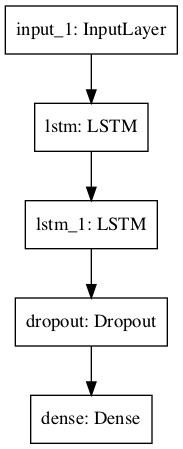

In [83]:
from tensorflow.python.keras.utils.vis_utils import plot_model
best_model, best_params = load_my_model(3, 1, data_type='textblob', reset=True)
plot_model(best_model, to_file=f"./predictions/textblob/best.png")